In [1]:
%%javascript
IPython.notebook.clear_all_output();

<IPython.core.display.Javascript object>

In [2]:
%reset -f
from IPython import get_ipython
get_ipython().magic('reset -sf')

%who

Interactive namespace is empty.


In [3]:
import os
import glob
import h5py
import shutil
import imgaug as aug
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib
# matplotlib.use('Agg')
import matplotlib.pyplot as plt
import matplotlib.image as mimg
import imgaug.augmenters as iaa
from os import listdir, makedirs, getcwd, remove
from os.path import isfile, join, abspath, exists, isdir, expanduser
from PIL import Image
from pathlib import Path
from skimage.io import imread
from skimage.transform import resize
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from mlxtend.plotting import plot_confusion_matrix
from sklearn.metrics import confusion_matrix
import cv2
# from keras import backend as K
color = sns.color_palette()
%matplotlib inline

import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator,load_img, img_to_array
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Dropout, Input, Flatten, SeparableConv2D
from tensorflow.keras.layers import GlobalMaxPooling2D
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam, SGD, RMSprop
from tensorflow.keras.callbacks import ModelCheckpoint, Callback, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.utils import to_categorical
os.environ['AUTOGRAPH_VERBOSITY'] = "10"
tf.autograph.set_verbosity(0)
tf.compat.v1.logging.set_verbosity(0)

import sys
import datetime
import time

print("Python version: ", sys.version)
print("Version info.: ", sys.version_info)
print("TensorFlow version: ", tf.__version__)
print("TensorFlow.Keras version : ", tf.keras.__version__)

Python version:  3.6.10 |Anaconda, Inc.| (default, Mar 23 2020, 23:13:11) 
[GCC 7.3.0]
Version info.:  sys.version_info(major=3, minor=6, micro=10, releaselevel='final', serial=0)
TensorFlow version:  2.1.0
TensorFlow.Keras version :  2.2.4-tf


In [4]:

# Turn interactive plotting off
# plt.ioff()
# Set the seed for hash based operations in python
os.environ['PYTHONHASHSEED'] = '0'

# Set the numpy seed
np.random.seed(111)

config = tf.compat.v1.ConfigProto()
config.gpu_options.allow_growth = True
config.log_device_placement = True
config.gpu_options.visible_device_list='0,1,2,3'

# Set the random seed in tensorflow at graph level
tf.compat.v1.set_random_seed(111)

# Set the session in tensorflow
sess = tf.compat.v1.Session(config=config)

# Set the session in keras
tf.compat.v1.keras.backend.set_session(sess)

# tf.debugging.set_log_device_placement(True)
# strategy = tf.distribute.MirroredStrategy()
strategy = tf.distribute.experimental.MultiWorkerMirroredStrategy()

print("#--#--"*10)
print('Number of devices: {}\n'.format(strategy.num_replicas_in_sync))

# from tensorflow.python.client import device_lib
# print(device_lib.list_local_devices())

# Make the augmentation sequence deterministic
aug.seed(111)


Device mapping:
/job:localhost/replica:0/task:0/device:XLA_CPU:0 -> device: XLA_CPU device
/job:localhost/replica:0/task:0/device:GPU:0 -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:04:00.0, compute capability: 6.0
/job:localhost/replica:0/task:0/device:GPU:1 -> device: 1, name: Tesla P100-PCIE-16GB, pci bus id: 0000:05:00.0, compute capability: 6.0
/job:localhost/replica:0/task:0/device:GPU:2 -> device: 2, name: Tesla P100-PCIE-16GB, pci bus id: 0000:84:00.0, compute capability: 6.0
/job:localhost/replica:0/task:0/device:GPU:3 -> device: 3, name: Tesla P100-PCIE-16GB, pci bus id: 0000:85:00.0, compute capability: 6.0
/job:localhost/replica:0/task:0/device:XLA_GPU:0 -> device: XLA_GPU device
/job:localhost/replica:0/task:0/device:XLA_GPU:1 -> device: XLA_GPU device
/job:localhost/replica:0/task:0/device:XLA_GPU:2 -> device: XLA_GPU device
/job:localhost/replica:0/task:0/device:XLA_GPU:3 -> device: XLA_GPU device

#--#--#--#--#--#--#--#--#--#--#--#--#--#--#--#--#--#--#--#--

In [5]:
# FileTime = str(datetime.datetime.now().strftime("%m-%d-%Y-%H-%M"))
FileTime = '04-15-2020-16-45'
print("#--#--"*10, "\nFile time: ", FileTime, "\n\n")

# Define path to the data directory
data_dir = Path('/data/user/tr27p/Courses/CS765-DeepLearning/FinalProject/Chest_X-Ray_Images_Pneumonia/Data/chest_xray/chest_xray/')

# Path to train directory (Fancy pathlib...no more os.path!!)
train_dir = data_dir / 'train'

# Path to validation directory
val_dir = data_dir / 'val'

# Path to test directory
test_dir = data_dir / 'test'


#--#--#--#--#--#--#--#--#--#--#--#--#--#--#--#--#--#--#--#-- 
File time:  04-15-2020-16-45 




In [6]:
# Get the path to the normal and pneumonia sub-directories
normal_cases_dir = train_dir / 'NORMAL'
pneumonia_cases_dir = train_dir / 'PNEUMONIA'

# Get the list of all the images
normal_cases = normal_cases_dir.glob('*.jpeg')
pneumonia_cases = pneumonia_cases_dir.glob('*.jpeg')

# An empty list. We will insert the data into this list in (img_path, label) format
train_data = []

# Go through all the normal cases. The label for these cases will be 0
for img in sorted(normal_cases):
    train_data.append((img,0))

# Go through all the pneumonia cases. The label for these cases will be 1
for img in sorted(pneumonia_cases):
    train_data.append((img, 1))

# Get a pandas dataframe from the data we have in our list
train_data = pd.DataFrame(train_data, columns=['image', 'label'],index=None)

# Shuffle the data
train_data = train_data.sample(random_state=111, frac=1.).reset_index(drop=True)
# train_data = train_data.sample(frac=1.).reset_index(drop=True)

# How the dataframe looks like?
print("#--#--"*10,"\n\n",train_data.head())


#--#--#--#--#--#--#--#--#--#--#--#--#--#--#--#--#--#--#--#-- 

                                                image  label
0  /data/user/tr27p/Courses/CS765-DeepLearning/Fi...      0
1  /data/user/tr27p/Courses/CS765-DeepLearning/Fi...      0
2  /data/user/tr27p/Courses/CS765-DeepLearning/Fi...      1
3  /data/user/tr27p/Courses/CS765-DeepLearning/Fi...      1
4  /data/user/tr27p/Courses/CS765-DeepLearning/Fi...      1


In [7]:
# Get the counts for each class
cases_count = train_data['label'].value_counts()
print(cases_count)

# Plot the results
# plt.figure(figsize=(10,8))
# sns.barplot(x=cases_count.index, y= cases_count.values)
# plt.title('Number of cases', fontsize=14)
# plt.xlabel('Case type', fontsize=12)
# plt.ylabel('Count', fontsize=12)
# plt.xticks(range(len(cases_count.index)), ['Normal(0)', 'Pneumonia(1)'])
# plt.show()


1    3875
0    1341
Name: label, dtype: int64


In [8]:
# Get few samples for both the classes
pneumonia_samples = (train_data[train_data['label']==1]['image'].iloc[:5]).tolist()
normal_samples = (train_data[train_data['label']==0]['image'].iloc[:5]).tolist()

# Concat the data in a single list and del the above two list
samples = pneumonia_samples + normal_samples
del pneumonia_samples, normal_samples

# Plot the data
# f, ax = plt.subplots(2,5, figsize=(30,10))
# for i in range(10):
#     img = imread(samples[i])
#     ax[i//5, i%5].imshow(img, cmap='gray')
#     if i<5:
#         ax[i//5, i%5].set_title("Pneumonia")
#     else:
#         ax[i//5, i%5].set_title("Normal")
#     ax[i//5, i%5].axis('off')
#     ax[i//5, i%5].set_aspect('auto')
# plt.show()


In [9]:
# Get the path to the sub-directories
normal_cases_dir = val_dir / 'NORMAL'
pneumonia_cases_dir = val_dir / 'PNEUMONIA'

# Get the list of all the images
normal_cases = normal_cases_dir.glob('*.jpeg')
pneumonia_cases = pneumonia_cases_dir.glob('*.jpeg')

# List that are going to contain validation images data and the corresponding labels
# An empty list. We will insert the data into this list in (img_path, label) format
valid_data = []


# Go through all the normal cases. The label for these cases will be 0
for img in sorted(normal_cases):
    valid_data.append((img,0))

# Go through all the pneumonia cases. The label for these cases will be 1
for img in sorted(pneumonia_cases):
    valid_data.append((img, 1))

# Get a pandas dataframe from the data we have in our list
valid_data = pd.DataFrame(valid_data, columns=['image', 'label'],index=None)

# Shuffle the data
valid_data = valid_data.sample(random_state=111, frac=1.).reset_index(drop=True)
# train_data = train_data.sample(frac=1.).reset_index(drop=True)

# How the dataframe looks like?
print("#--#--"*10,"\n\n",valid_data.head())


#--#--#--#--#--#--#--#--#--#--#--#--#--#--#--#--#--#--#--#-- 

                                                image  label
0  /data/user/tr27p/Courses/CS765-DeepLearning/Fi...      1
1  /data/user/tr27p/Courses/CS765-DeepLearning/Fi...      0
2  /data/user/tr27p/Courses/CS765-DeepLearning/Fi...      0
3  /data/user/tr27p/Courses/CS765-DeepLearning/Fi...      1
4  /data/user/tr27p/Courses/CS765-DeepLearning/Fi...      0


In [10]:
# Augmentation sequence
seq = iaa.OneOf([
    iaa.Fliplr(), # horizontal flips
    iaa.Affine(rotate=20), # roatation
    iaa.Multiply((1.2, 1.5))]) #random brightness


In [11]:
def data_gen(data, batch_size, augment=False):
    # Get total number of samples in the data
    n = len(data)
    steps = n//batch_size

    # Define two numpy arrays for containing batch data and labels
    batch_data = np.zeros((batch_size, 224, 224, 3), dtype=np.float32)
    batch_labels = np.zeros((batch_size,2), dtype=np.float32)

    # Get a numpy array of all the indices of the input data
    indices = np.arange(n)

    # Initialize a counter
    i =0
    while True:
#         np.random.shuffle(indices)
        # Get the next batch
        count = 0
        next_batch = indices[(i*batch_size):(i+1)*batch_size]
        for j, idx in enumerate(next_batch):
            img_name = data.iloc[idx]['image']
            label = data.iloc[idx]['label']
#             print("IMG-NAME: ", str(img_name).split("/")[-1])
            # one hot encoding
            encoded_label = to_categorical(label, num_classes=2)
            # read the image and resize
            img = cv2.imread(str(img_name))
            img = cv2.resize(img, (224,224))

            # check if it's grayscale
            if img.shape[2]==1:
                img = np.dstack([img, img, img])

            # cv2 reads in BGR mode by default
            orig_img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            # normalize the image pixels
            orig_img = img.astype(np.float32)/255.

            batch_data[count] = orig_img
            batch_labels[count] = encoded_label


#             count+=1
            # generating more samples of the undersampled class
            if augment:
                if label==0 and count < batch_size-2:
                    aug_img1 = seq.augment_image(img)
                    aug_img2 = seq.augment_image(img)
                    aug_img1 = cv2.cvtColor(aug_img1, cv2.COLOR_BGR2RGB)
                    aug_img2 = cv2.cvtColor(aug_img2, cv2.COLOR_BGR2RGB)
                    aug_img1 = aug_img1.astype(np.float32)/255.
                    aug_img2 = aug_img2.astype(np.float32)/255.

                    batch_data[count+1] = aug_img1
                    batch_labels[count+1] = encoded_label
                    batch_data[count+2] = aug_img2
                    batch_labels[count+2] = encoded_label
                    count +=2

                else:
                    count+=1
            else:
                count+=1

            if count==batch_size:
                break

        i+=1
        yield (batch_data, batch_labels)

        if i>=steps:
            i=0


In [12]:
# a =  data_gen(data=train_data, batch_size=16)
# for x, y in a:
#     for img, lab in zip(x,y):
#         plt.title(lab)
#         plt.imshow(img, cmap='gray')
#         plt.show()
#     break

In [13]:
def build_model():
    input_img = Input(shape=(224,224,3), name='ImageInput')
    x = Conv2D(64, (3,3), activation='relu', padding='same', name='Conv1_1')(input_img)
    x = Conv2D(64, (3,3), activation='relu', padding='same', name='Conv1_2')(x)
    x = MaxPooling2D((2,2), name='pool1')(x)

    x = SeparableConv2D(128, (3,3), activation='relu', padding='same', name='Conv2_1')(x)
    x = SeparableConv2D(128, (3,3), activation='relu', padding='same', name='Conv2_2')(x)
    x = MaxPooling2D((2,2), name='pool2')(x)

    x = SeparableConv2D(256, (3,3), activation='relu', padding='same', name='Conv3_1')(x)
    x = BatchNormalization(name='bn1')(x)
    x = SeparableConv2D(256, (3,3), activation='relu', padding='same', name='Conv3_2')(x)
    x = BatchNormalization(name='bn2')(x)
    x = SeparableConv2D(256, (3,3), activation='relu', padding='same', name='Conv3_3')(x)
    x = MaxPooling2D((2,2), name='pool3')(x)

    x = SeparableConv2D(512, (3,3), activation='relu', padding='same', name='Conv4_1')(x)
    x = BatchNormalization(name='bn3')(x)
    x = SeparableConv2D(512, (3,3), activation='relu', padding='same', name='Conv4_2')(x)
    x = BatchNormalization(name='bn4')(x)
    x = SeparableConv2D(512, (3,3), activation='relu', padding='same', name='Conv4_3')(x)
    x = MaxPooling2D((2,2), name='pool4')(x)

    # x = SeparableConv2D(512, (3,3), activation='relu', padding='same', name='Conv5_1')(x)
    # x = BatchNormalization(name='bn5')(x)
    # x = SeparableConv2D(512, (3,3), activation='relu', padding='same', name='Conv5_2')(x)
    # x = BatchNormalization(name='bn6')(x)
    # x = SeparableConv2D(512, (3,3), activation='relu', padding='same', name='Conv5_3')(x)
    # x = MaxPooling2D((2,2), name='pool5')(x)

    x = Flatten(name='flatten')(x)
    x = Dense(1024, activation='relu', name='fc1')(x)
    x = Dropout(0.7, name='dropout1')(x)
    x = Dense(512, activation='relu', name='fc2')(x)
    x = Dropout(0.5, name='dropout2')(x)
    x = Dense(2, activation='softmax', name='fc3')(x)

    model = Model(inputs=input_img, outputs=x)
    return model

In [14]:
with strategy.scope():
    model =  build_model()
    # opt = RMSprop(lr=1e-4, clipnorm=1.)
    opt = Adam(lr=1e-4, amsgrad=True, clipnorm=1.)
    model.compile(loss='binary_crossentropy', metrics=['accuracy', tf.keras.metrics.AUC()],optimizer=opt)

In [15]:
print(model.summary())

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
ImageInput (InputLayer)      [(None, 224, 224, 3)]     0         
_________________________________________________________________
Conv1_1 (Conv2D)             (None, 224, 224, 64)      1792      
_________________________________________________________________
Conv1_2 (Conv2D)             (None, 224, 224, 64)      36928     
_________________________________________________________________
pool1 (MaxPooling2D)         (None, 112, 112, 64)      0         
_________________________________________________________________
Conv2_1 (SeparableConv2D)    (None, 112, 112, 128)     8896      
_________________________________________________________________
Conv2_2 (SeparableConv2D)    (None, 112, 112, 128)     17664     
_________________________________________________________________
pool2 (MaxPooling2D)         (None, 56, 56, 128)       0     

In [16]:
# with strategy.scope():
#     # Open the VGG16 weight file
#     f = h5py.File('/data/user/tr27p/Courses/CS765-DeepLearning/FinalProject/Chest_X-Ray_Images_Pneumonia/Data/vgg16/vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5', 'r')

#     # Select the layers for which you want to set weight.

#     w,b = f['block1_conv1']['block1_conv1_W_1:0'], f['block1_conv1']['block1_conv1_b_1:0']
#     model.layers[1].set_weights = [w,b]

#     w,b = f['block1_conv2']['block1_conv2_W_1:0'], f['block1_conv2']['block1_conv2_b_1:0']
#     model.layers[2].set_weights = [w,b]

#     w,b = f['block2_conv1']['block2_conv1_W_1:0'], f['block2_conv1']['block2_conv1_b_1:0']
#     model.layers[4].set_weights = [w,b]

#     w,b = f['block2_conv2']['block2_conv2_W_1:0'], f['block2_conv2']['block2_conv2_b_1:0']
#     model.layers[5].set_weights = [w,b]

# f.close()
# print(model.summary())


In [17]:
# Callback for printing the LR at the end of each epoch.
class PrintLR(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        print('\nLearning rate for epoch {} is {}\n'.format(epoch + 1, model.optimizer.lr.numpy()))


In [18]:
# batch_size = 16
nb_epochs = 20
BUFFER_SIZE = len(train_data)

BATCH_SIZE_PER_REPLICA = 80
BATCH_SIZE = BATCH_SIZE_PER_REPLICA * strategy.num_replicas_in_sync
batch_size = BATCH_SIZE

callbacks = [
#     tf.keras.callbacks.TensorBoard(log_dir='./logs'),
    ReduceLROnPlateau(monitor='val_auc', factor=.5, patience=3, verbose=1, mode='max'),
    # EarlyStopping(  monitor='val_loss', min_delta=1e-3, patience=5, verbose=1,
    #                 mode='auto', baseline=None, restore_best_weights=True),
    ModelCheckpoint(filepath='/data/user/tr27p/Courses/CS765-DeepLearning/FinalProject/Chest_X-Ray_Images_Pneumonia/Python/best_model_todate_python/'+FileTime+'/',
                    monitor='val_auc', verbose=1,
                    save_best_only=True, save_weights_only=True),
    PrintLR()
]

# Get a train data generator
train_data_gen = data_gen(data=train_data, batch_size=batch_size)

# Get a valid data generator
val_data_gen = data_gen(data=valid_data, batch_size=batch_size)

# Define the number of training steps
nb_train_steps = train_data.shape[0]//batch_size

# Define the number of validation steps
nb_valid_steps = valid_data.shape[0]//batch_size

print("#--#--"*10,"\n\nNumber of training and validation steps: {} and {}".format(nb_train_steps, nb_valid_steps))#len(valid_data)


#--#--#--#--#--#--#--#--#--#--#--#--#--#--#--#--#--#--#--#-- 

Number of training and validation steps: 16 and 0


In [19]:
# print("#--#--"*10,  "\n UPDATED MODEL BASED ON VGG16")

print("#--#--"*10,  "\n BATCH_SIZE_PER_REPLICA = ", BATCH_SIZE_PER_REPLICA,
                    "\n BATCH_SIZE = ", BATCH_SIZE,
                    "\n EPOCHS = ", nb_epochs)

def print_inventory(inventory_name, dct):
    print('%s :' %(inventory_name))
    for item, amount in dct.items():  # dct.iteritems() in Python 2
        print('%15s : %s' % (item, amount))

print("#--#--"*10)
print_inventory("Optimizer", opt.get_config())
# print("#--#--"*10)
# print_inventory("Early Stopping", opt.get_config())
# print("#--#--"*10)
# print_inventory("Reduce LR On Plateau", opt.get_config())

print('\nReduce LR On Plateau :\n%15s : %s,\n%15s : %s,\n%15s : %s,\n%15s : %s' %  ('Monitor', callbacks[0].monitor,
                                                                                    'Factor', callbacks[0].factor,
                                                                                    'Mode', callbacks[0].mode,
                                                                                    'Patience', callbacks[0].patience) )

# print('\n Early Stopping:\n%15s : %s,\n%15s : %s,\n%15s : %s' %('Monitor', callbacks[1].monitor,
#                                                                 'MinDelta', callbacks[1].min_delta,
#                                                                 'patience', callbacks[1].patience) )


#--#--#--#--#--#--#--#--#--#--#--#--#--#--#--#--#--#--#--#-- 
 BATCH_SIZE_PER_REPLICA =  80 
 BATCH_SIZE =  320 
 EPOCHS =  20
#--#--#--#--#--#--#--#--#--#--#--#--#--#--#--#--#--#--#--#--
Optimizer :
           name : Adam
       clipnorm : 1.0
  learning_rate : 0.0001
          decay : 0.0
         beta_1 : 0.9
         beta_2 : 0.999
        epsilon : 1e-07
        amsgrad : True

Reduce LR On Plateau :
        Monitor : val_auc,
         Factor : 0.5,
           Mode : max,
       Patience : 3


In [20]:
weightPath = '/data/user/tr27p/Courses/CS765-DeepLearning/FinalProject/Chest_X-Ray_Images_Pneumonia/Python/xray-best-model/best_model/best_model_para-tune_'+FileTime+'.hdf5'

In [21]:
print("#--#--"*10,"\n\nweightPath: ", weightPath)

with strategy.scope():
    model.load_weights(weightPath)

#--#--#--#--#--#--#--#--#--#--#--#--#--#--#--#--#--#--#--#-- 

weightPath:  /data/user/tr27p/Courses/CS765-DeepLearning/FinalProject/Chest_X-Ray_Images_Pneumonia/Python/xray-best-model/best_model/best_model_para-tune_04-15-2020-16-45.hdf5


In [27]:
# Preparing test data
normal_cases_dir = test_dir / 'NORMAL'
pneumonia_cases_dir = test_dir / 'PNEUMONIA'

normal_cases = normal_cases_dir.glob('*.jpeg')
pneumonia_cases = pneumonia_cases_dir.glob('*.jpeg')

val_normal_cases_dir = val_dir / 'NORMAL'
val_pneumonia_cases_dir = val_dir / 'PNEUMONIA'

val_normal_cases = val_normal_cases_dir.glob('*.jpeg')
val_pneumonia_cases = val_pneumonia_cases_dir.glob('*.jpeg')

train_normal_cases_dir = train_dir / 'NORMAL'
train_pneumonia_cases_dir = train_dir / 'PNEUMONIA'

train_normal_cases = train_normal_cases_dir.glob('*.jpeg')
train_pneumonia_cases = train_pneumonia_cases_dir.glob('*.jpeg')

test_data = []
test_labels = []

for img in normal_cases:
    img = cv2.imread(str(img))
    img = cv2.resize(img, (224,224))
    if img.shape[2] ==1:
        img = np.dstack([img, img, img])
    else:
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = img.astype(np.float32)/255.
    label = to_categorical(0, num_classes=2)
    test_data.append(img)
    test_labels.append(label)

# for img in val_normal_cases:
#     img = cv2.imread(str(img))
#     img = cv2.resize(img, (224,224))
#     if img.shape[2] ==1:
#         img = np.dstack([img, img, img])
#     else:
#         img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
#     img = img.astype(np.float32)/255.
#     label = to_categorical(0, num_classes=2)
#     test_data.append(img)
#     test_labels.append(label)
    
# for img in train_normal_cases:
#     img = cv2.imread(str(img))
#     img = cv2.resize(img, (224,224))
#     if img.shape[2] ==1:
#         img = np.dstack([img, img, img])
#     else:
#         img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
#     img = img.astype(np.float32)/255.
#     label = to_categorical(0, num_classes=2)
#     test_data.append(img)
#     test_labels.append(label)
    
for img in pneumonia_cases:
    img = cv2.imread(str(img))
    img = cv2.resize(img, (224,224))
    if img.shape[2] ==1:
        img = np.dstack([img, img, img])
    else:
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = img.astype(np.float32)/255.
    label = to_categorical(1, num_classes=2)
    test_data.append(img)
    test_labels.append(label)

# for img in val_pneumonia_cases:
#     img = cv2.imread(str(img))
#     img = cv2.resize(img, (224,224))
#     if img.shape[2] ==1:
#         img = np.dstack([img, img, img])
#     else:
#         img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
#     img = img.astype(np.float32)/255.
#     label = to_categorical(1, num_classes=2)
#     test_data.append(img)
#     test_labels.append(label)
    
# for img in train_pneumonia_cases:
#     img = cv2.imread(str(img))
#     img = cv2.resize(img, (224,224))
#     if img.shape[2] ==1:
#         img = np.dstack([img, img, img])
#     else:
#         img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
#     img = img.astype(np.float32)/255.
#     label = to_categorical(1, num_classes=2)
#     test_data.append(img)
#     test_labels.append(label)
    
test_data = np.array(test_data)
test_labels = np.array(test_labels)

print("#--#--"*10,"\n\nTotal number of test examples: ", test_data.shape)
print("#--#--"*10,"\n\nTotal number of labels:", test_labels.shape)


#--#--#--#--#--#--#--#--#--#--#--#--#--#--#--#--#--#--#--#-- 

Total number of test examples:  (624, 224, 224, 3)
#--#--#--#--#--#--#--#--#--#--#--#--#--#--#--#--#--#--#--#-- 

Total number of labels: (624, 2)


In [28]:
# Evaluation on test dataset
with strategy.scope():
    test_loss, test_score, test_auc = model.evaluate(test_data, test_labels, batch_size=batch_size)
print("Loss on test set: ", test_loss)
print("Accuracy on test set: ", test_score)
print("AUC on test set: ", test_auc)


624/624 [==============================] - 9s 15ms/sample - loss: 2.1136 - accuracy: 0.7516 - auc: 0.7963
Loss on test set:  2.113645783183762
Accuracy on test set:  0.7516026
AUC on test set:  0.7963189


In [29]:
# Get predictions
with strategy.scope():
    preds = model.predict(test_data, batch_size=batch_size)
preds = np.argmax(preds, axis=-1)

# Original labels
orig_test_labels = np.argmax(test_labels, axis=-1)

print("#--#--"*10,"\n\n",orig_test_labels.shape)
print("#--#--"*10,"\n\n",preds.shape)


#--#--#--#--#--#--#--#--#--#--#--#--#--#--#--#--#--#--#--#-- 

 (624,)
#--#--#--#--#--#--#--#--#--#--#--#--#--#--#--#--#--#--#--#-- 

 (624,)


<Figure size 432x288 with 0 Axes>

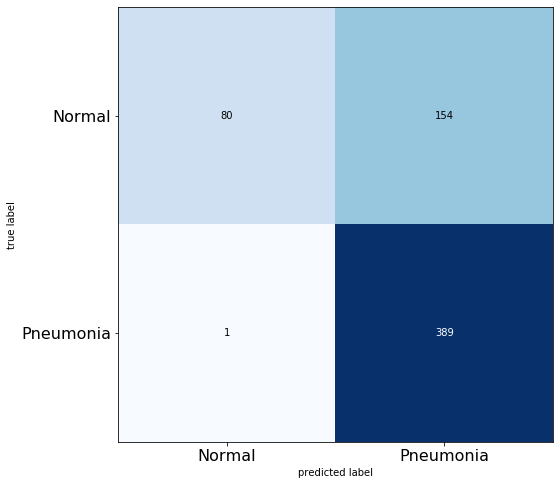

In [30]:
# Get the confusion matrix
cm  = confusion_matrix(orig_test_labels, preds)
fig = plt.figure()
plot_confusion_matrix(cm,figsize=(12,8), hide_ticks=True,cmap=plt.cm.Blues)
plt.xticks(range(2), ['Normal', 'Pneumonia'], fontsize=16)
plt.yticks(range(2), ['Normal', 'Pneumonia'], fontsize=16)
#plt.savefig("/data/user/tr27p/Courses/CS765-DeepLearning/FinalProject/Chest_X-Ray_Images_Pneumonia/Python/python_confusion-mat.png", format='png')
# plt.savefig('/data/user/tr27p/Courses/CS765-DeepLearning/FinalProject/Chest_X-Ray_Images_Pneumonia/Python/plots/confusion-mat/python_confusion-mat-'+FileTime+'.png', format='png')
plt.show()
plt.close()

In [26]:
# Calculate Precision and Recall
tn, fp, fn, tp = cm.ravel()

precision = tp/(tp+fp)
recall = tp/(tp+fn)

print("#--#--"*10,"\n\nRecall of the model is {:.2f}".format(recall))
print("#--#--"*10,"\n\nPrecision of the model is {:.2f}".format(precision))

#--#--#--#--#--#--#--#--#--#--#--#--#--#--#--#--#--#--#--#-- 

Recall of the model is 1.00
#--#--#--#--#--#--#--#--#--#--#--#--#--#--#--#--#--#--#--#-- 

Precision of the model is 0.72
